In [3]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, RocCurveDisplay
)

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 50)
RANDOM_STATE = 42
DATA_DIR = Path(".")
train_path = DATA_DIR / "train.csv"
test_path = DATA_DIR / "test.csv"

In [4]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(f"Train shape: {train_df.shape}")
print(f"Test shape:  {test_df.shape}")
train_df.head()

Train shape: (891, 12)
Test shape:  (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
missing = train_df.isnull().mean().sort_values(ascending=False)
print("Missing rate (sorted):")
print((missing * 100).round(1).astype(str) + "%")

train_df.describe(include="all")

Missing rate (sorted):
Cabin          77.1%
Age            19.9%
Embarked        0.2%
PassengerId     0.0%
Name            0.0%
Pclass          0.0%
Survived        0.0%
Sex             0.0%
Parch           0.0%
SibSp           0.0%
Fare            0.0%
Ticket          0.0%
dtype: object


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


## Quick EDA plots

A few simple visuals to see class balance and important signals.

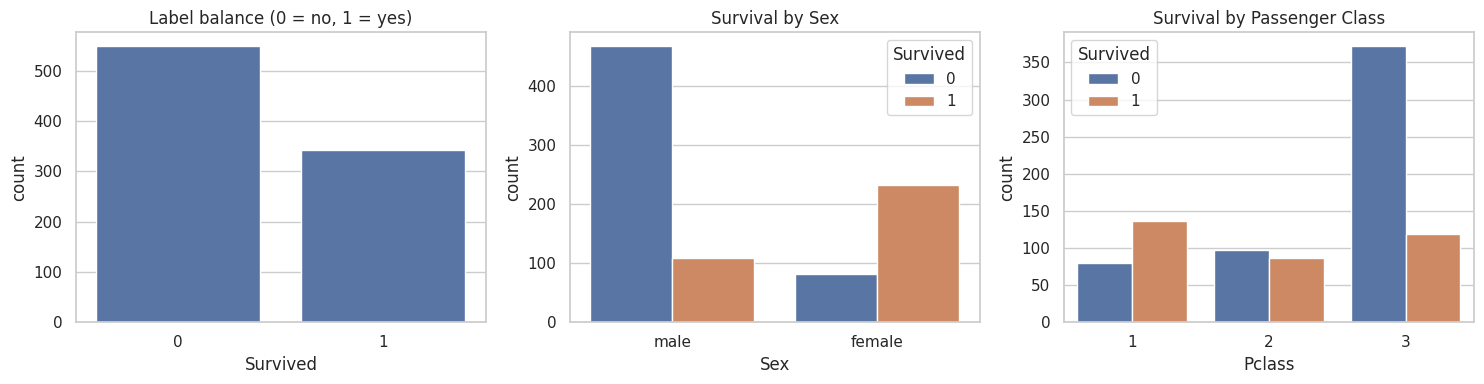

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.countplot(data=train_df, x="Survived", ax=axes[0])
axes[0].set_title("Label balance (0 = no, 1 = yes)")

sns.countplot(data=train_df, x="Sex", hue="Survived", ax=axes[1])
axes[1].set_title("Survival by Sex")

sns.countplot(data=train_df, x="Pclass", hue="Survived", ax=axes[2])
axes[2].set_title("Survival by Passenger Class")

plt.tight_layout();

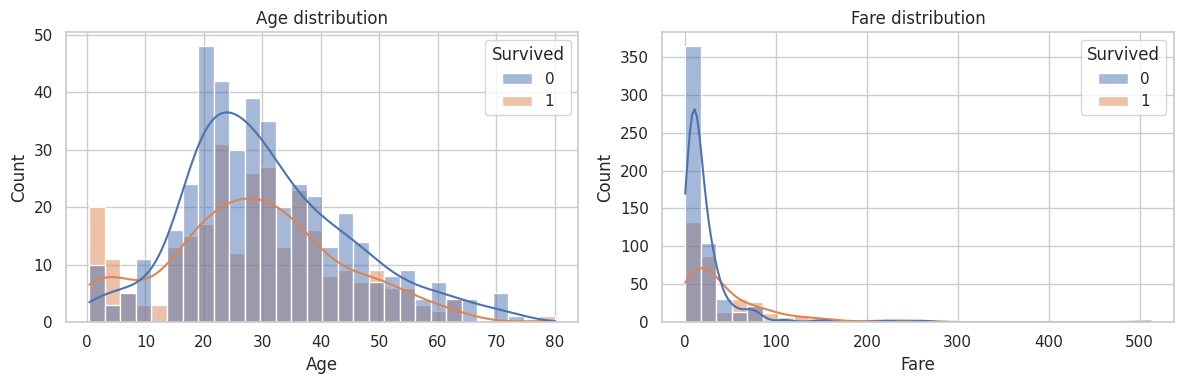

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data=train_df, x="Age", hue="Survived", kde=True, bins=30, ax=axes[0])
axes[0].set_title("Age distribution")

sns.histplot(data=train_df, x="Fare", hue="Survived", kde=True, bins=30, ax=axes[1])
axes[1].set_title("Fare distribution")

plt.tight_layout();

## Plan for features and cleaning

We keep it simple but meaningful:

- Fill missing numbers with the median (robust to outliers).

- Fill missing categories with the most frequent value.

- Create a few intuitive features: passenger title, family size, is alone, cabin deck initial, ticket prefix/group size.

- One-hot encode categorical columns; scale numeric columns.

- Train two models: logistic regression (baseline) and random forest (captures non-linearities).

In [9]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    """Lightweight, readable feature engineering for the Titanic data."""
    df = df.copy()

    # Titles like Mr, Mrs, Dr (group rare ones so we don't overfit)
    df["Title"] = df["Name"].str.extract(r",\s*([^.]+)\.")
    title_map = {
        "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs",
        "Lady": "Royal", "Countess": "Royal", "Sir": "Royal", "Dona": "Royal", "Don": "Royal", "Jonkheer": "Royal",
        "Capt": "Officer", "Col": "Officer", "Major": "Officer", "Dr": "Officer", "Rev": "Officer",
    }
    df["Title"] = df["Title"].replace(title_map).fillna("Unknown")

    # Family info
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

    # Cabin deck initial (Unknown if missing)
    df["CabinDeck"] = df["Cabin"].fillna("Unknown").astype(str).str[0]

    # Ticket prefix (strip numbers and dots); group size capped to avoid huge values
    df["TicketPrefix"] = df["Ticket"].str.replace(r"[\.\d]", "", regex=True).str.strip()
    df["TicketPrefix"] = df["TicketPrefix"].replace("", "None")
    df["TicketGroupSize"] = df.groupby("Ticket")["Ticket"].transform("count").fillna(1).clip(upper=4)

    return df

feature_cols_num = ["Age", "Fare", "SibSp", "Parch", "FamilySize"]
feature_cols_cat = ["Sex", "Pclass", "Embarked", "Title", "CabinDeck", "IsAlone", "TicketPrefix", "TicketGroupSize"]

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer([
    ("num", numeric_pipeline, feature_cols_num),
    ("cat", categorical_pipeline, feature_cols_cat),
])

baseline_model = Pipeline([
    ("features", FunctionTransformer(add_features)),
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=400, random_state=RANDOM_STATE)),
])

rf_model = Pipeline([
    ("features", FunctionTransformer(add_features)),
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=6,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )),
])

target_col = "Survived"
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_valid.shape

((712, 11), (179, 11))

## Train baseline: logistic regression

Fast, interpretable starting point.

In [10]:
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_valid)
y_proba = baseline_model.predict_proba(X_valid)[:, 1]

metrics = {
    "accuracy": accuracy_score(y_valid, y_pred),
    "precision": precision_score(y_valid, y_pred),
    "recall": recall_score(y_valid, y_pred),
    "f1": f1_score(y_valid, y_pred),
    "roc_auc": roc_auc_score(y_valid, y_proba),
}
metrics

{'accuracy': 0.8379888268156425,
 'precision': 0.8125,
 'recall': 0.7536231884057971,
 'f1': 0.7819548872180451,
 'roc_auc': 0.8714097496706192}

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       110
           1       0.81      0.75      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



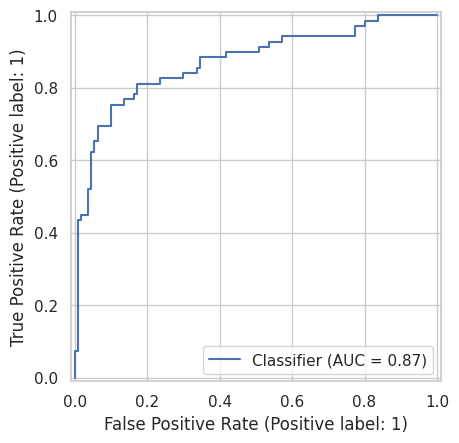

In [11]:
print(classification_report(y_valid, y_pred))
RocCurveDisplay.from_predictions(y_valid, y_proba);
plt.show()

## Train a second model: random forest

Tree ensemble to catch non-linear patterns.

In [12]:
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_valid)
rf_proba = rf_model.predict_proba(X_valid)[:, 1]

rf_metrics = {
    "accuracy": accuracy_score(y_valid, rf_pred),
    "precision": precision_score(y_valid, rf_pred),
    "recall": recall_score(y_valid, rf_pred),
    "f1": f1_score(y_valid, rf_pred),
    "roc_auc": roc_auc_score(y_valid, rf_proba),
}
rf_metrics

{'accuracy': 0.8156424581005587,
 'precision': 0.7903225806451613,
 'recall': 0.7101449275362319,
 'f1': 0.7480916030534351,
 'roc_auc': 0.8378787878787879}

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       110
           1       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



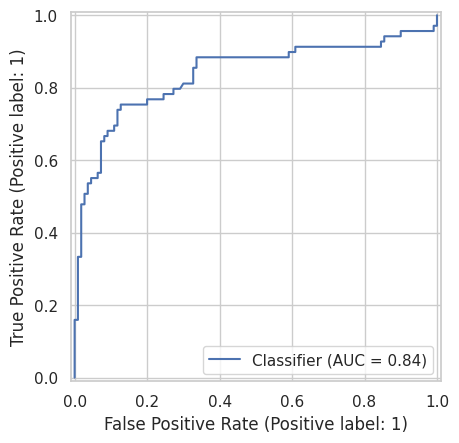

In [13]:
print(classification_report(y_valid, rf_pred))
RocCurveDisplay.from_predictions(y_valid, rf_proba);
plt.show()

## Pick the better model and fit on all training data

We pick the model with the higher ROC AUC on the validation split, then retrain it on the full training set.

In [14]:
use_rf = rf_metrics["roc_auc"] >= metrics["roc_auc"]
chosen_model = rf_model if use_rf else baseline_model
chosen_name = "RandomForest" if use_rf else "LogisticRegression"
print(f"Chosen model based on ROC AUC: {chosen_name}")

chosen_model.fit(X, y)

Chosen model based on ROC AUC: LogisticRegression


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('features', ...), ('preprocess', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function add...x7c4802996ca0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments to

In [15]:
test_preds = chosen_model.predict(test_df)

submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": test_preds.astype(int),
})
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [16]:
output_path = DATA_DIR / "submission.csv"
submission.to_csv(output_path, index=False)
print(f"Saved file: {output_path}")

Saved file: submission.csv
